In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SEED = 42

In [3]:
latent_vectors = np.load('../vectors/latent_vector_18376.npy')
original = np.load('../vectors/originales.npy')
labels = np.load('../vectors/labels_originales.npy')

lv = pd.DataFrame(latent_vectors)
og = pd.DataFrame(original)

print(lv.info())
print(og.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 18376 entries, 0 to 18375
dtypes: float32(18376)
memory usage: 7.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 110250 entries, 0 to 110249
dtypes: float32(110250)
memory usage: 42.1 MB
None


In [ ]:
latent_size = lv.shape[1]

### K-means

In [ ]:
k = 10
kmeans_lv = make_pipeline(StandardScaler(), KMeans(n_clusters=k, max_iter=30, n_init=20, random_state=SEED))
kmeans_lv.fit(lv)
print(kmeans_lv[1].labels_)

In [ ]:
print(kmeans_lv[1].labels_[21])
print(kmeans_lv[1].labels_[54])

In [ ]:
k = 10
kmeans = make_pipeline(StandardScaler(), KMeans(n_clusters=k, max_iter=30, n_init=20, random_state=SEED))
kmeans.fit(og)
print(kmeans[1].labels_)

In [ ]:
print(kmeans[1].labels_[21])
print(kmeans[1].labels_[54])

c:\Users\gaston\miniconda3\envs\td6\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\gaston\miniconda3\envs\td6\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\gaston\miniconda3\envs\td6\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\gaston\miniconda3\envs\td6\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMe

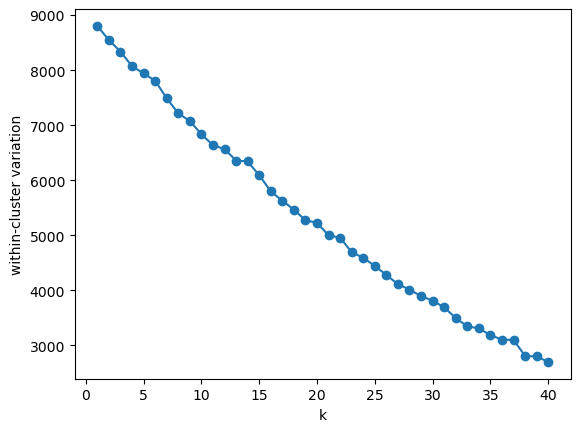

In [4]:
evol_variabilidad = []
for k in range(1, 41):
    kmeans = KMeans(n_clusters=k, max_iter=30, n_init=20)
    kmeans.fit(lv)
    evol_variabilidad.append({"k": k, "var": kmeans.inertia_})

evol_variabilidad = pd.DataFrame(evol_variabilidad)
plt.figure()
plt.plot(evol_variabilidad["k"], evol_variabilidad["var"], marker="o")
plt.xlabel("k")
plt.ylabel("within-cluster variation")
plt.show()

### Heatmap

In [ ]:
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

# Assuming the columns are features and rows are latent vectors, transpose the DataFrame for visualization
heatmap = sns.heatmap(lv[:15].T, cmap='coolwarm', annot=True, fmt=".2f")  # Transpose with .T to visualize rows as vectors
plt.title('Heatmap of Latent Vectors')
plt.xlabel('Latent Vectors')
plt.ylabel('Features')
plt.show()

### Decision Tree (feature importante)

In [ ]:
X = og
y = pd.DataFrame(labels)

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(X, y)

# Get feature importances from the trained model
feature_importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Num of top features
num_top_features = 25

# Get the indices of the top 'num_top_features' most important features
top_indices = indices[:num_top_features]

# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({feature_importances[indices[f]]})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title(f"Top {num_top_features} Feature Importances (original vector)")
plt.bar(range(num_top_features), feature_importances[top_indices], align="center")
plt.xticks(range(num_top_features), top_indices, rotation=45)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

### PCA

In [ ]:
scaler = StandardScaler(with_std=True, with_mean=True)
scaled_lv = pd.DataFrame(scaler.fit_transform(lv))

pca = PCA()
pca.fit(scaled_lv)

# Crea un DataFrame para almacenar los resultados del PCA
scores = pd.DataFrame(pca.transform(scaled_lv), index=scaled_lv.index)
# print(scores.head())

# Veamos qué valores de los loadings se obtuvieron (cada fila es un vector de loadins)
loadings = pca.components_

def plot_biplot(pca_res, scores):
    """
    Función para crear un gráfico biplot a partir de los resultados del PCA.
    """
    i, j = 0, 1
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Grafica las puntuaciones en el espacio de las dos primeras componentes principales
    ax.scatter(scores.values[:, 0], scores.values[:, 1])
    ax.set_xlabel('PC%d' % (i + 1))
    ax.set_ylabel('PC%d' % (j + 1))
    
    # Agrega flechas y etiquetas para las cargas de las variables en el biplot
    for k in range(pca_res.components_.shape[1]):
        ax.arrow(0, 0, pca_res.components_[i, k], pca_res.components_[j, k])
        ax.text(pca_res.components_[i, k], pca_res.components_[j, k], lv.columns[k])
    
    # Agrega etiquetas a las observaciones
    for k, txt in enumerate(scores.index):
        ax.annotate(txt, (scores.values[k, 0], scores.values[k, 1]), fontsize=8, color='gray')
    
    # Agrega líneas verticales y horizontales en el origen
    ax.axvline(0, color='lightgray', linestyle='--')
    ax.axhline(0, color='lightgray', linestyle='--')

    plt.show()

# Llama a la función plot_biplot para crear el biplot
plot_biplot(pca, scores)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 

def plot_biplot_3d(pca_res, scores):
    """
    Función para crear un gráfico 3D a partir de los resultados del PCA.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    i, j, k = 0, 1, 2  # Elejo las 3 primeras componentes principales
    
    # Plotteo de scores en las 3 dimensiones
    ax.scatter(scores.values[:, i], scores.values[:, j], scores.values[:, k])
    ax.set_xlabel('PC%d' % (i + 1))
    ax.set_ylabel('PC%d' % (j + 1))
    ax.set_zlabel('PC%d' % (k + 1))
    
    # Añado etiquetas para identificar canciones
    for n, txt in enumerate(scores.index):
        ax.text(scores.values[n, i], scores.values[n, j], scores.values[n, k], txt, fontsize=8, color='gray')
    
    plt.legend()
    plt.show()

plot_biplot_3d(pca, scores)